<a href="https://colab.research.google.com/github/osgeokr/ESDA/blob/main/ESDA_%EA%B3%B5%EA%B0%84_%EC%9E%90%EA%B8%B0%EC%83%81%EA%B4%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESDA: 공간 자기상관(Spatial Autocorrelation)

코드 출처: https://pysal.org/esda/notebooks/spatialautocorrelation.html

In [ ]:
# 패키지 설치
!pip install geopandas -q
!pip install mapclassify -q
!pip install pysal -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.7/243.7 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 KB 

In [ ]:
# 나눔고딕 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import os
os.kill(os.getpid(), 9) # 런타임 종료

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 2s (5,559 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
# 패키지 호출
import pandas as pd
import geopandas as gpd
import folium
from google.colab import files
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')

import libpysal as lps
import esda

from splot.esda import plot_moran, moran_scatterplot, lisa_cluster
from esda.moran import Moran, Moran_Local

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-1-33bf83fe39ea>:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  impo

## 표준지공시지가정보

* 매년 1월 1일을 기준으로 표준지의 단위면적당 가격정보 (원/㎡)
* 바로가기: http://openapi.nsdi.go.kr/nsdi/eios/ServiceDetail.do?svcSe=F&svcId=F013

In [ ]:
# 진주시 표준지공시지가 DataFrame
data_df = pd.read_csv('https://raw.githubusercontent.com/osgeokr/ESDA/main/DATA/JINJU_PRICE.csv')
data_df.head()

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A16,A17,A18,A19,A20,A21,A22,A23,xcoord,ycoord
0,4812534036202430000,4812534036,경상남도 창원시 마산합포구 진전면 고사리,2,산,243,산243임,2022,1,2400,...,농림지역,720,자연림,5,삼각형,12,맹지,2022/08/21,1.078762e+06,1.683194e+06
1,4817042026104500006,4817042026,경상남도 진주시 집현면 정수리,1,일반,450-6,450-6 답,2022,1,27500,...,생산관리지역,610,답,4,사다리형,6,소로한면,2022/08/21,1.052703e+06,1.700845e+06
2,4817044026105020002,4817044026,경상남도 진주시 명석면 신기리,1,일반,502-2,502-2 대,2022,1,40000,...,계획관리지역,110,단독,5,삼각형,8,세로한면(가),2022/08/21,1.048380e+06,1.699743e+06
3,4817040021108790000,4817040021,경상남도 진주시 대곡면 설매리,1,일반,879,879 전,2022,1,18000,...,계획관리지역,510,전,5,삼각형,12,맹지,2022/08/21,1.060891e+06,1.698576e+06
4,4817044023102250001,4817044023,경상남도 진주시 명석면 남성리,1,일반,225-1,225-1 전,2022,1,10000,...,보전관리지역,510,전,5,삼각형,10,세로한면(불),2022/08/21,1.050278e+06,1.699830e+06


In [ ]:
# 진주시 표준지공시지가 GeoDataFrame
data_gdf = gpd.GeoDataFrame(data_df, geometry=gpd.points_from_xy(data_df.xcoord, data_df.ycoord), crs='EPSG:5179')
data_gdf.head()

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A17,A18,A19,A20,A21,A22,A23,xcoord,ycoord,geometry
0,4812534036202430000,4812534036,경상남도 창원시 마산합포구 진전면 고사리,2,산,243,산243임,2022,1,2400,...,720,자연림,5,삼각형,12,맹지,2022/08/21,1.078762e+06,1.683194e+06,POINT (1078761.560 1683194.383)
1,4817042026104500006,4817042026,경상남도 진주시 집현면 정수리,1,일반,450-6,450-6 답,2022,1,27500,...,610,답,4,사다리형,6,소로한면,2022/08/21,1.052703e+06,1.700845e+06,POINT (1052702.657 1700845.331)
2,4817044026105020002,4817044026,경상남도 진주시 명석면 신기리,1,일반,502-2,502-2 대,2022,1,40000,...,110,단독,5,삼각형,8,세로한면(가),2022/08/21,1.048380e+06,1.699743e+06,POINT (1048380.349 1699742.848)
3,4817040021108790000,4817040021,경상남도 진주시 대곡면 설매리,1,일반,879,879 전,2022,1,18000,...,510,전,5,삼각형,12,맹지,2022/08/21,1.060891e+06,1.698576e+06,POINT (1060890.786 1698575.920)
4,4817044023102250001,4817044023,경상남도 진주시 명석면 남성리,1,일반,225-1,225-1 전,2022,1,10000,...,510,전,5,삼각형,10,세로한면(불),2022/08/21,1.050278e+06,1.699830e+06,POINT (1050278.306 1699829.579)


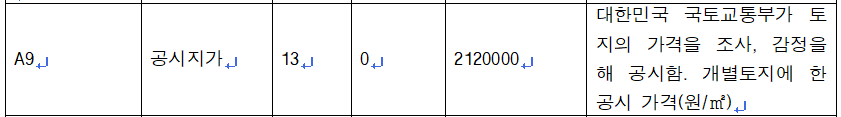

Text(0.5, 1.0, '진주시 공시지가')

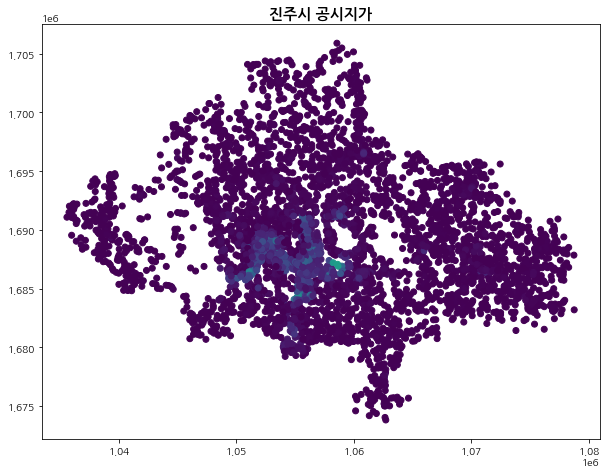

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
data_gdf.plot(ax=ax, column='A9')
ax.set_title('진주시 공시지가', fontsize=15, fontweight='bold')

In [ ]:
len(data_gdf)

5237

## 법정구역정보
* 법정동의 경계구역을 표시한 정보
* 바로가기: http://openapi.nsdi.go.kr/nsdi/eios/ServiceDetail.do?svcSe=F&svcId=F001

In [ ]:
# 진주시 법정구역정보(읍면동) GeoDataFrame
nbr_gdf = gpd.read_file('https://raw.githubusercontent.com/osgeokr/ESDA/main/DATA/JINJU_ADM.geojson')
nbr_gdf.head()

,A0,A1,A2,A3,geometry
0,305,48170129,판문동,2022-11-23,"MULTIPOLYGON (((1048840.967 1685593.175, 10488..."
1,306,48170126,평거동,2022-11-23,"MULTIPOLYGON (((1050063.502 1687614.405, 10501..."
2,1925,48170122,초전동,2022-11-23,"MULTIPOLYGON (((1057047.894 1691326.538, 10570..."
3,1926,48170420,집현면,2022-11-23,"MULTIPOLYGON (((1055557.823 1691590.960, 10555..."
4,1911,48170127,이현동,2022-11-23,"MULTIPOLYGON (((1048967.990 1690191.710, 10489..."


Text(0.5, 1.0, '진주시 법정구역')

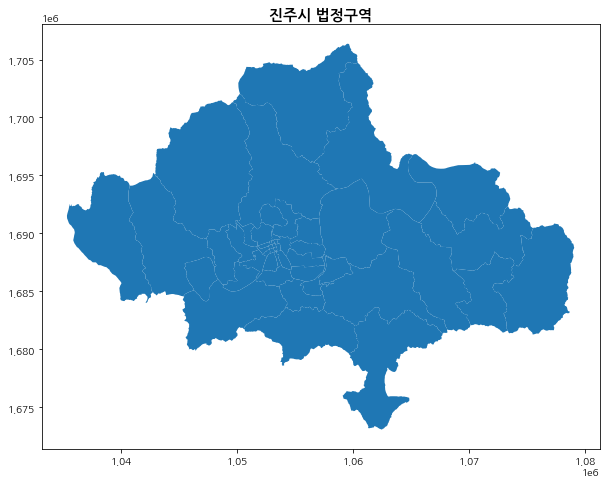

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
nbr_gdf.plot(ax=ax)
ax.set_title('진주시 법정구역', fontsize=15, fontweight='bold')

In [ ]:
len(nbr_gdf)

49

## 공간 조인(Spatial Join)

In [ ]:
# 공간 조인(Spatial Join)
prices = gpd.sjoin(nbr_gdf, data_gdf[['A9','geometry']], op='contains')
prices.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,A0,A1,A2,A3,geometry,index_right,A9
0,305,48170129,판문동,2022-11-23,"MULTIPOLYGON (((1048840.967 1685593.175, 10488...",4288,1420000
0,305,48170129,판문동,2022-11-23,"MULTIPOLYGON (((1048840.967 1685593.175, 10488...",3695,734500
0,305,48170129,판문동,2022-11-23,"MULTIPOLYGON (((1048840.967 1685593.175, 10488...",3607,570000
0,305,48170129,판문동,2022-11-23,"MULTIPOLYGON (((1048840.967 1685593.175, 10488...",3374,458500
0,305,48170129,판문동,2022-11-23,"MULTIPOLYGON (((1048840.967 1685593.175, 10488...",3610,477500


In [ ]:
len(prices)

5223

In [ ]:
pd.options.display.float_format = '{:.1f}'.format

# 법정구역별 평균 공시지가
nbr_avg_price = prices['A9'].groupby([prices['A2']]).mean()
nbr_final = nbr_gdf.merge(nbr_avg_price, on='A2')
nbr_final.rename(columns={'A2': 'adm'}, inplace=True)
nbr_final.rename(columns={'A9': 'avg_price'}, inplace=True)
nbr_final.head()

,A0,A1,adm,A3,geometry,avg_price
0,305,48170129,판문동,2022-11-23,"MULTIPOLYGON (((1048840.967 1685593.175, 10488...",223839.1
1,306,48170126,평거동,2022-11-23,"MULTIPOLYGON (((1050063.502 1687614.405, 10501...",1078855.4
2,1925,48170122,초전동,2022-11-23,"MULTIPOLYGON (((1057047.894 1691326.538, 10570...",832282.9
3,1926,48170420,집현면,2022-11-23,"MULTIPOLYGON (((1055557.823 1691590.960, 10555...",64400.8
4,1911,48170127,이현동,2022-11-23,"MULTIPOLYGON (((1048967.990 1690191.710, 10489...",393777.3


In [ ]:
len(nbr_final)

49

## 단계구분도(Choropleth: 코로플레스)

In [ ]:
# 단계구분도
m = folium.Map(location=[35.1847, 128.1131], zoom_start=11)
folium.TileLayer('CartoDB positron').add_to(m)

title = '진주시 법정구역별 평균 공시지가'
title_html = '''
             <h3 align="center"><b>{}</b></h3>
             '''.format(title)
m.get_root().html.add_child(folium.Element(title_html))

choropleth = folium.Choropleth(geo_data=nbr_final,
    data=nbr_final,
    bins=5, # 5단계
    columns=['adm', 'avg_price'],
    key_on='feature.properties.adm',
    line_color='black',
    line_width=1,
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.5,
    legend_name='평균 공시지가(원/㎡, 기준일: 2022.9.29.)'
).add_to(m)
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['adm','avg_price'], labels=True, localize=True))

m.save('JINJU_ADM_AVG_PRICE.html')
files.download('JINJU_ADM_AVG_PRICE.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

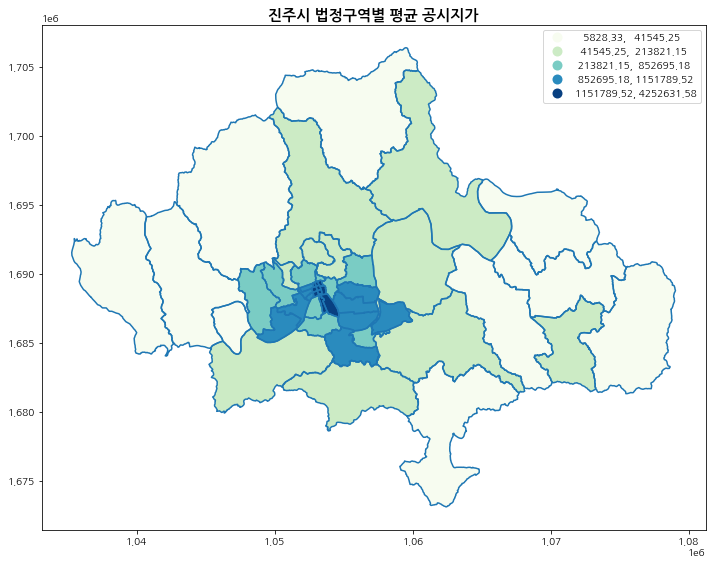

In [ ]:
# 단계구분도(5분위수)
fig, ax = plt.subplots(figsize=(10,10))
nbr_final.plot(column='avg_price', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax) # 분위수
nbr_final.boundary.plot(ax=ax)
plt.title('진주시 법정구역별 평균 공시지가', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## 유사성(Similarity: 시밀러리티) 측정

In [ ]:
# 공간 유사성(Spatial similarity)
w =  lps.weights.Queen.from_dataframe(nbr_final)
w.transform = 'r'

# 속성 유사성(Attribute similarity)
nbr_final['weighted_price'] = lps.weights.lag_spatial(w, nbr_final['avg_price'])
nbr_final.head()

,A0,A1,adm,A3,geometry,avg_price,weighted_price
0,305,48170129,판문동,2022-11-23,"MULTIPOLYGON (((1048840.967 1685593.175, 10488...",223839.1,271006.8
1,306,48170126,평거동,2022-11-23,"MULTIPOLYGON (((1050063.502 1687614.405, 10501...",1078855.4,458197.9
2,1925,48170122,초전동,2022-11-23,"MULTIPOLYGON (((1057047.894 1691326.538, 10570...",832282.9,373501.7
3,1926,48170420,집현면,2022-11-23,"MULTIPOLYGON (((1055557.823 1691590.960, 10555...",64400.8,252460.1
4,1911,48170127,이현동,2022-11-23,"MULTIPOLYGON (((1048967.990 1690191.710, 10489...",393777.3,569942.1


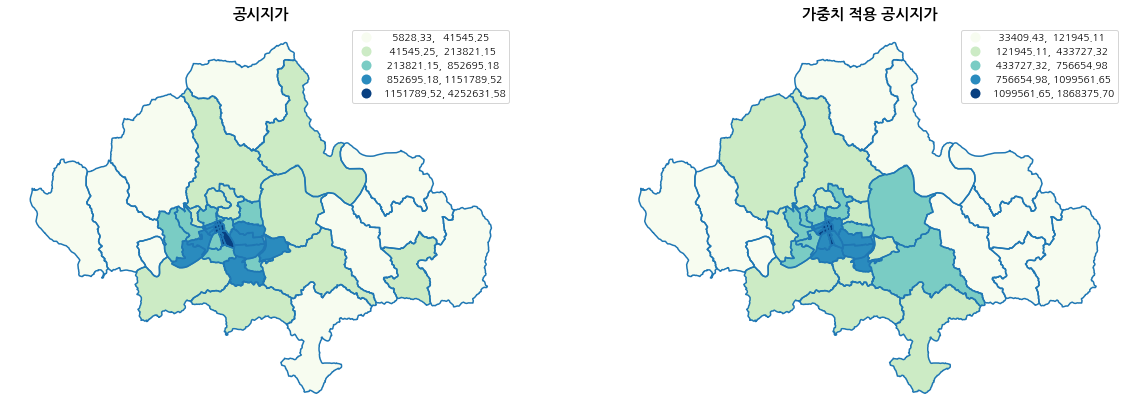

In [ ]:
f,ax = plt.subplots(1,2,figsize=(20,10))

nbr_final.plot(column='avg_price', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax[0]) # 분위수
nbr_final.boundary.plot(ax=ax[0])
ax[0].set_title("공시지가", fontsize=15, fontweight='bold')
ax[0].axis('off')

nbr_final.plot(column='weighted_price', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax[1]) # 분위수
nbr_final.boundary.plot(ax=ax[1])
ax[1].set_title("가중치 적용 공시지가", fontsize=15, fontweight='bold')
ax[1].axis('off')

plt.show()

# 광역적 공간 자기상관(Global Spatial Autocorrelation)

In [ ]:
# 광역적 공간 자기상관
y = nbr_final.avg_price
moran = esda.Moran(y, w)
moran.I, moran.p_sim # Moran의 I값, p-값

(0.5579910239314347, 0.001)

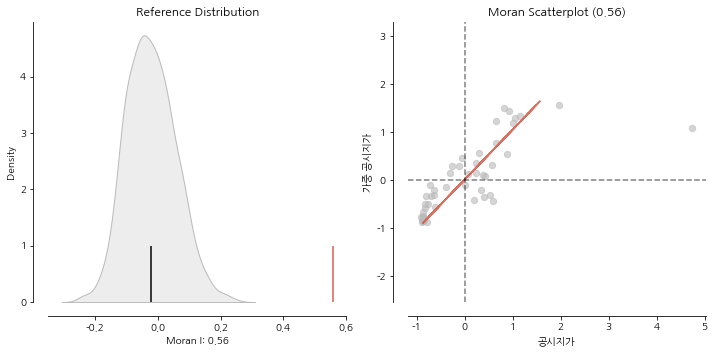

In [ ]:
plot_moran(moran, zstandard=True, figsize=(10,5))

plt.rcParams['axes.unicode_minus'] = False
plt.ylabel('가중 공시지가')
plt.xlabel('공시지가')
plt.tight_layout()
plt.show()

## 지역적 공간 자기상관(Local Spatial Autocorrelation)

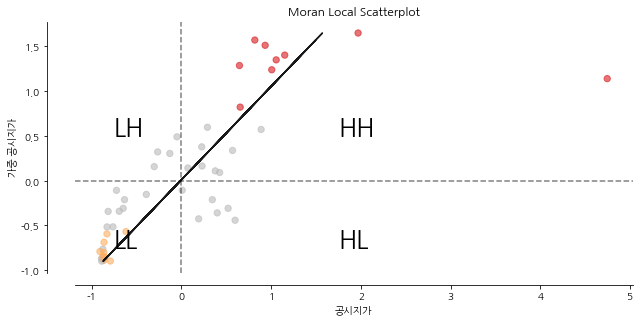

In [ ]:
# 지역 공간 자기상관
moran_local = Moran_Local(y, w)

fig, ax = plt.subplots(figsize=(10,10))
moran_scatterplot(Moran_Local(y, w), p=0.05, ax=ax)
ax.set_xlabel('공시지가')
ax.set_ylabel('가중 공시지가')
plt.text(1.75, 0.50, 'HH', fontsize=25)
plt.text(1.75, -0.75, 'HL', fontsize=25)
plt.text(-0.75, 0.50, 'LH', fontsize=25)
plt.text(-0.75, -0.75, 'LL', fontsize=25)
plt.show()

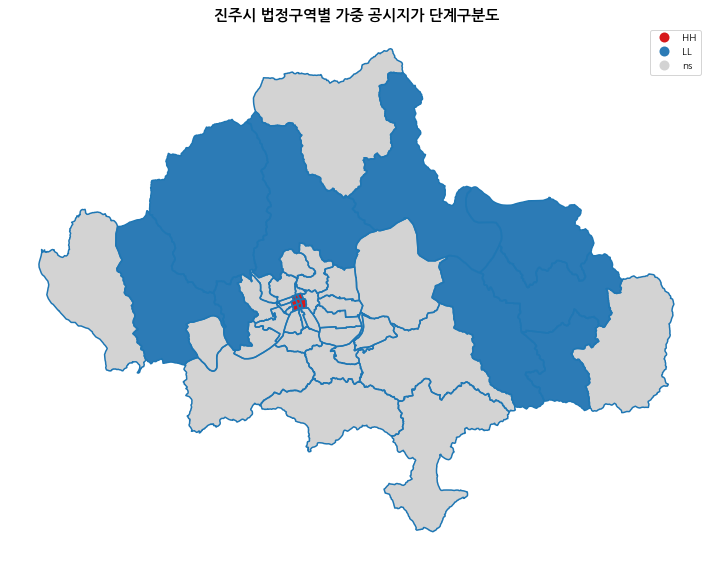

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
fig = lisa_cluster(moran_local, nbr_final, p=0.05, ax=ax)
nbr_final.boundary.plot(ax=ax)
plt.title('진주시 법정구역별 가중 공시지가 단계구분도', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()